In [1]:
import pandas as pd
import gc
import sys
import os
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
src_path = os.path.abspath(r'C:\Users\User\OneDrive - Imperial College London\Desktop\Documents\GitHub\Credit-Card\src')
sys.path.append(src_path)

from adtk.data import validate_series
from adtk.detector import QuantileAD, ThresholdAD
from adtk.visualization import plot

from feature_engineering.encoding import group_low_frequency_categories, encode_categories, log_encode
from feature_engineering.new_features import extract_bin, calculate_time_for_n_transactions
from data.db_functions import query_data
from data.clean_data import update_dtypes

In [2]:
db_dir = r'C:\Users\User\OneDrive - Imperial College London\Desktop\Documents\GitHub\Credit-Card\data\database (SQLite)\raw_data.db'

query = "SELECT * FROM raw_data"

with sqlite3.connect(db_dir) as conn:
    df = pd.read_sql_query(query, conn)


df.head()

,business_id,auth_status,eci,descriptor,auth_failure_reason,charge_failure_reason,amount,authorized_amount,mid_label,bank_merchant_id,...,country,currency,ip_address,masked_card_number,card_holder_name,card_type,is_blocked_by_fraud,is_cvn_submitted,should_authenticate_credit_card,should_settle_directly
0,640fdf71d95a90ebc209167d,USED,5.0,"GLOBE TELECOM, INC.",None,None,1449.0,1449.0,MPGS_GLOBE_BILLSPAY,073006686104,...,PHILIPPINES,PHP,None,40289391XXXX6107,None,CREDIT,0,1,1.0,1
1,6334094342466a489b1a8843,USED,1.0,XDT*MGC OLEA ENTERPRISE,None,FRAUD_RISK_BLOCKED,864.0,864.0,PAYMAYA_5399,103496912,...,BRAZIL,PHP,175.176.38.157,53055118XXXX4428,wqewq eqweqw,CREDIT,1,0,1.0,0
2,611b0b5386b56c40a81cb987,USED,5.0,AIRPAZ,None,None,3916248.0,3916248.0,XENDIT_AIRPAZ,100812034023,...,UNKNOWN,IDR,193.36.225.154,45350602XXXX2895,None,DEBIT,0,1,1.0,1
3,61975b2e9a388541fb103616,USED,NaN,XDT*AUTOSWEEP RFID,None,None,400.0,400.0,MAYA_AUTOSWEEP_4784,200015031,...,PHILIPPINES,PHP,111.90.226.237,54880939XXXX2063,None,CREDIT,0,1,1.0,0
4,640fdf71d95a90ebc209167d,USED,2.0,"GLOBE TELECOM, INC.",None,None,599.0,599.0,MPGS_GLOBE_BILLSPAY,073006686104,...,PHILIPPINES,PHP,None,54523520XXXX1362,None,CREDIT,0,1,1.0,1


In [3]:

df = update_dtypes(df)
# df['is_fraud'] = df['charge_failure_reason'].apply(lambda x: 1 if pd.isna(x) else 0)
df_copy = df.copy()

df = df[df['charge_failure_reason'].notna()]
df['card_bin'] = extract_bin(df, 'masked_card_number')
df = df.sort_values(by=['card_bin', 'created'], ascending=[True, True])

thresholds = list(range(5, 61, 5))
for num in thresholds:
    df[f'time_{num}th_transaction'] = calculate_time_for_n_transactions(df, time_column='created', n=num)


df = df.sort_values(by='created', ascending=True)
df.set_index('created', drop=False, inplace=True)




df_copy['card_bin'] = extract_bin(df_copy, 'masked_card_number')
df_copy = df_copy.sort_values(by='created', ascending=True)


thresholds = list(range(5, 61, 5))
for num in thresholds:
    df_copy[f'time_{num}th_transaction'] = calculate_time_for_n_transactions(df_copy, time_column='created', n=num)

df = df.sort_values(by='created', ascending=True)
df.set_index('created', drop=False, inplace=True)

C:\Users\User\OneDrive - Imperial College London\Desktop\Documents\GitHub\Credit-Card\src\data\clean_data.py:76: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[column] = df[column].replace({1: True, 0: False, 'true': True, 'false': False, 'True': True, 'False': False}).astype('boolean')


Total rows: 3553562
Number of rows dropped: 0


C:\Users\User\OneDrive - Imperial College London\Desktop\Documents\GitHub\Credit-Card\src\feature_engineering\new_features.py:276: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  time_difference.fillna(0, inplace=True)
C:\Users\User\OneDrive - Imperial College London\Desktop\Documents\GitHub\Credit-Card\src\feature_engineering\new_features.py:276: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  time_difference.fillna(0, inplace=True)
C:\Users\User\OneDrive - Imperial College London\Desktop\Documents\GitHub\Credit-Card\src\feature_engineering\new_features.py:276: SettingWithCopyWarning: modifications to a method of a datetimelike object are not supported and are discarded. Change values on the original.
  time_difference.fillna(0, inplace=True)
C:\Users\User\OneDrive - Imperial College London\Des

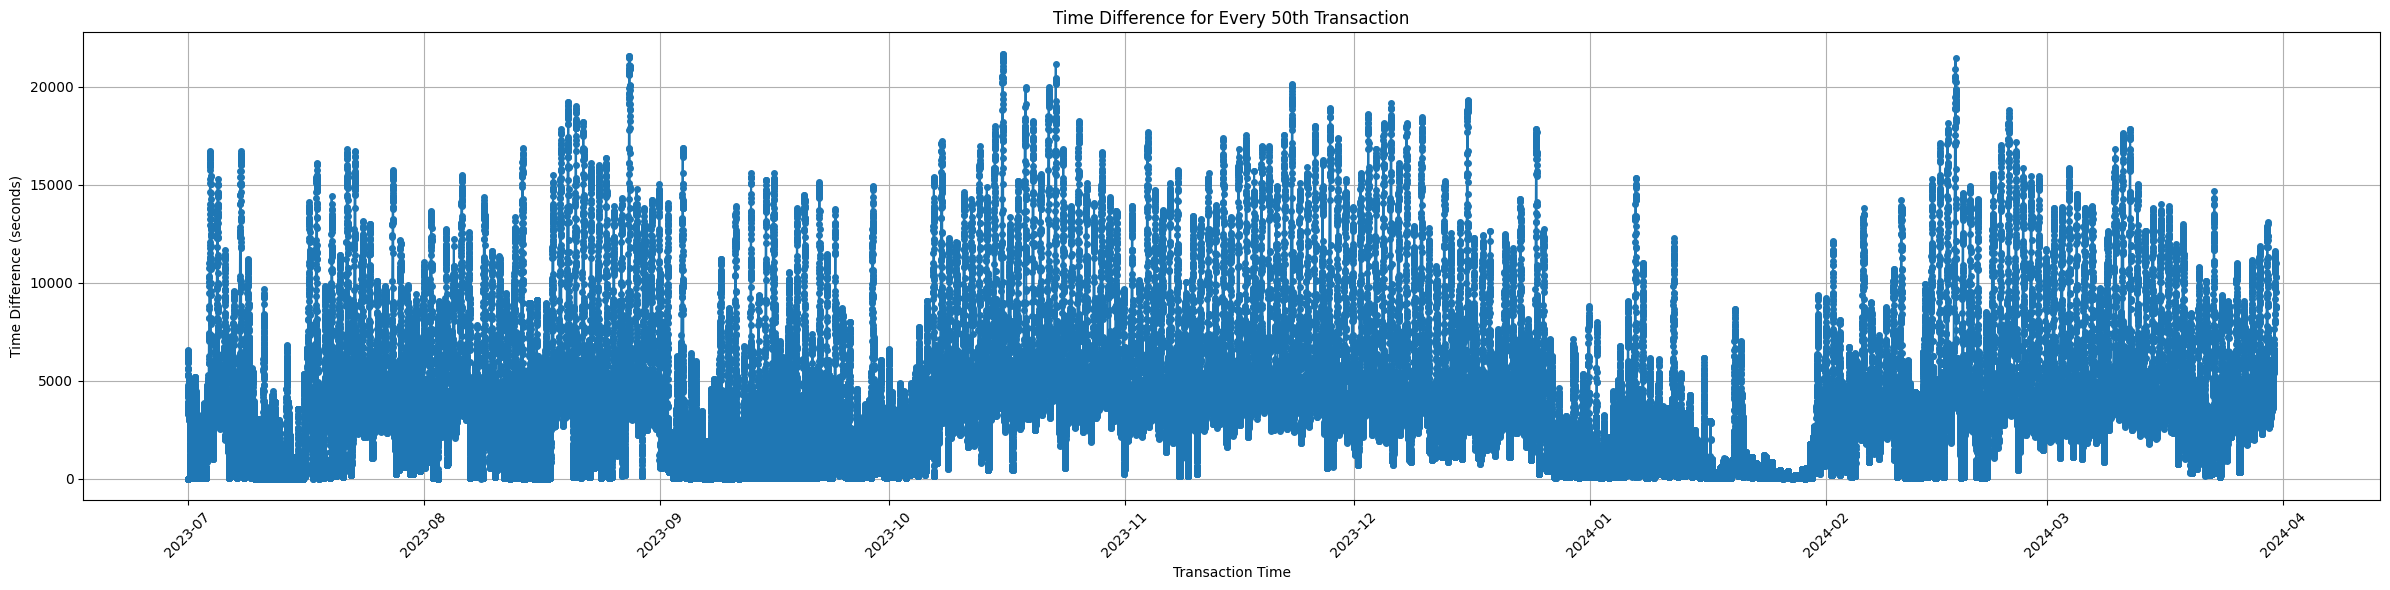

In [10]:
plt.figure(figsize=(24, 6))

n = 50
# Plot with the index as time
plt.plot(df.index, df[f'time_{n}th_transaction'], marker='o', linestyle='-', markersize=4)
plt.title(f'Time Difference for Every {n}th Transaction')
plt.xlabel('Transaction Time')
plt.ylabel('Time Difference (seconds)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

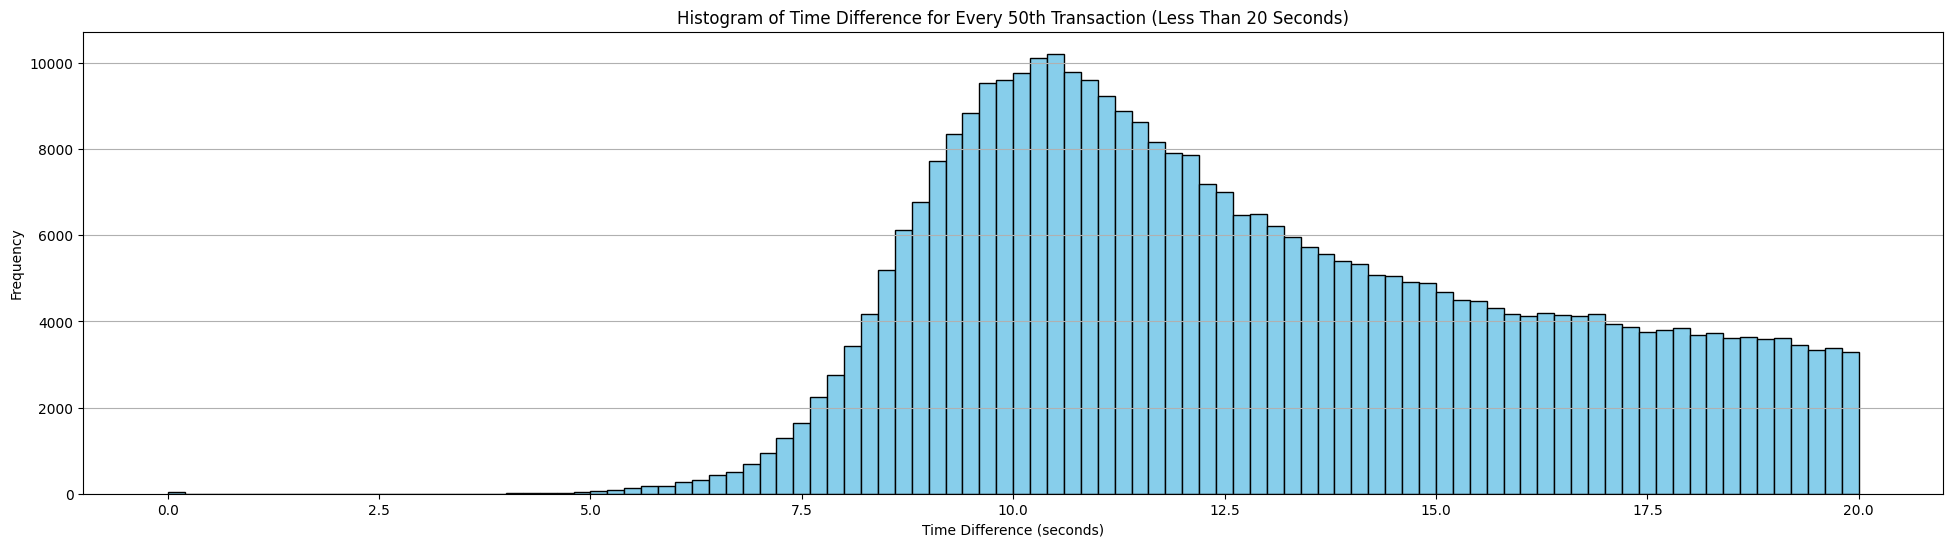

In [11]:
plt.figure(figsize=(24, 6))

m = 20
# Filter for time differences less than 10 seconds
plt.hist(df[df[f'time_{n}th_transaction'] < m][f'time_{n}th_transaction'], bins=100, color='skyblue', edgecolor='black')
plt.title(f'Histogram of Time Difference for Every {n}th Transaction (Less Than {m} Seconds)')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.grid(axis='y')

# Show the plot
plt.show()

In [9]:
# Define time intervals and set up initial data
time_intervals = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
na = df_copy['charge_failure_reason'].isna().sum()

# Dictionary to store failure rates for each interval and threshold
failure_rates_by_time_interval = {}
lowest_failure_rate = float('inf')
lowest_rate_info = None

# Loop over each interval
for interval in time_intervals:
    time_column = f'time_{interval}th_transaction'
    
    # Check if the column exists in df
    if time_column in df.columns:
        failure_rates_by_time_interval[time_column] = {}
        
        # Loop over each threshold in time_intervals
        for threshold in time_intervals:
            df_filtered = df[df[time_column] < threshold]
            failure_rate = len(df_filtered) / (na + len(df_filtered))

            # Store failure rate
            failure_rates_by_time_interval[time_column][f'<{threshold}'] = failure_rate
            
            # Check if this is the lowest failure rate found so far
            if failure_rate < lowest_failure_rate:
                lowest_failure_rate = failure_rate
                lowest_rate_info = (time_column, f'<{threshold}')

            # Print result for each threshold
            print(f'Failure rate for {time_column} < {threshold}: {failure_rate}')

# Print summary
print("\nSummary of failure rates for different time_nth_transaction intervals and thresholds:")
for time_col, rates in failure_rates_by_time_interval.items():
    print(f"{time_col}:")
    for threshold, rate in rates.items():
        print(f"  {threshold}: {rate}")

# Print lowest failure rate
print(f"\nLowest failure rate: {lowest_failure_rate} for {lowest_rate_info[0]} at {lowest_rate_info[1]}")



Failure rate for time_5th_transaction < 5: 0.4377409409346586
Failure rate for time_5th_transaction < 10: 0.5028228286140514
Failure rate for time_5th_transaction < 15: 0.5263074930627133
Failure rate for time_5th_transaction < 20: 0.5380414850356215
Failure rate for time_5th_transaction < 25: 0.545265874795936
Failure rate for time_5th_transaction < 30: 0.5503871738146477
Failure rate for time_5th_transaction < 35: 0.5542437912159334
Failure rate for time_5th_transaction < 40: 0.5572934779318792
Failure rate for time_5th_transaction < 45: 0.5596931208999952
Failure rate for time_5th_transaction < 50: 0.5616859081089263
Failure rate for time_10th_transaction < 5: 0.29137480738399657
Failure rate for time_10th_transaction < 10: 0.4095472615687029
Failure rate for time_10th_transaction < 15: 0.4633331249183344
Failure rate for time_10th_transaction < 20: 0.490868819013088
Failure rate for time_10th_transaction < 25: 0.5066169363832371
Failure rate for time_10th_transaction < 30: 0.517245

In [7]:
failure_rate_baseline = len(df)/len(df_copy)
print(f'failure_rate_baseline: {failure_rate_baseline}')


na = df_copy['charge_failure_reason'].isna().sum()
failure_rate_filtered = len(df[df['time_10th_transaction'] <= 10])/(df_copy['charge_failure_reason'].isna().sum() + len(df[df['time_10th_transaction'] <= 10]))
print(f'failure_rate_filtered: {failure_rate_filtered}')


failure_rate_baseline: 0.5966267086376993
failure_rate_filtered: 0.40956647532178236
